In [1]:
!pip install patchify
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import*
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np
import cv2 
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,ReduceLROnPlateau,EarlyStopping,TensorBoard
from tensorflow.keras.layers import*
from tensorflow.keras.models import Model

In [2]:
hp = {}
hp["image_size"] = 200
hp["num_channels"] = 3
hp["patch_size"] = 25
hp["num_patches"] = (hp["image_size"]**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])

hp["batch_size"] = 32
hp["lr"] = 1e-4
hp["num_epochs"] = 500
hp["num_classes"] = 5
hp["class_names"] = ['carcinoma','functional dysphonia','healthy','paresis','polyp']

hp["num_layers"] = 12
hp["hidden_dim"] = 768
hp["mlp_dim"] = 3072
hp["num_heads"] = 12
hp["dropout_rate"] = 0.1
hp['num_heads']=12

In [3]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()
    def build(self,input_shape):
        w_init=tf.random_normal_initializer()
        self.w=tf.Variable(initial_value=w_init(shape=(1,1,input_shape[-1]),dtype=tf.float32),
                       trainable=True)
    def call(self,inputs):
        batch_size=tf.shape(inputs)[0]
        hidden_dim=self.w.shape[-1]
        cls=tf.broadcast_to(self.w,[batch_size,1,hidden_dim])
        cls=tf.cast(cls,dtype=inputs.dtype)
        return cls

In [4]:
def mlp(x,cf):
    x=Dense(cf['mlp_dim'],activation='gelu')(x)
    x=Dropout(cf['dropout_rate'])(x)
    x=Dense(cf['hidden_dim'])(x)
    return x

In [5]:
def transformer_encoder(x ,cf):
    skip_1=x
    x=LayerNormalization()(x)
    x=MultiHeadAttention(
      num_heads=cf['num_heads'],key_dim=cf['hidden_dim']
  )(x,x)
    x=Add()([x,skip_1])
    skip_2=x
    x=LayerNormalization()(x)
    x=mlp(x,cf)
    x=Add()([x,skip_2])
    return x

In [6]:
def ViT(cf):
    input_shape=(cf['num_patches'],cf['patch_size']*cf['patch_size']*cf['num_channels'])
    inputs=Input(input_shape)
    patch_embed=Dense(cf['hidden_dim'])(inputs)
    positions=tf.range(start=0,limit=cf['num_patches'],delta=1)
    pos_embed=Embedding(input_dim=cf['num_patches'],output_dim=cf['hidden_dim'])(positions)
    embed=patch_embed+pos_embed ##(none,256,768)

  #adding class token
    token=ClassToken()(embed)
    x=Concatenate(axis=1)([token,embed]) ##(None, 257, 768)
    for _ in range(cf['num_layers']):
        x=transformer_encoder(x,cf) ##(None, 257, 768)
    x=LayerNormalization()(x)
    x=x[:,0,:]##(None, 768)
    x=Dense(cf['num_classes'],activation='softmax')(x)
    model=Model(inputs,x)
    return model


In [7]:
def load_data(path,split=0.2):
    images=shuffle(glob(os.path.join(path,'*',"*_rgb.png")))
    split_size=int(len(images)*split)
    xtrain,xtest=train_test_split(images,test_size=split_size,random_state=42)
    return xtrain,xtest

In [8]:
def process_image_label(path):
    """ Reading images """
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image/255.0

    """ Preprocessing to patches """
    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])

    # patches = np.reshape(patches, (64, 25, 25, 3))
    # for i in range(64):
    #     cv2.imwrite(f"files/{i}.png", patches[i])

    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    """ Label """
    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return patches, class_idx


In [9]:
def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels

def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds

In [10]:
if __name__=='__main__':
    np.random.seed(42)
    tf.random.set_seed(42)
    #creat_dir('files')
    dataset_path='/kaggle/input/vocalfold-segmentation/dataset/train'
    model_path=os.path.join('files','model.h5')
    csv_path=os.path.join('files','log.csv')
    xtrain,xtest=load_data(dataset_path)
    train_ds=tf_dataset(xtrain,batch=hp['batch_size'])
    valid_ds=tf_dataset(xtest,batch=hp['batch_size'])
  

In [11]:
    dataset_path='/kaggle/input/vocalfold-segmentation/dataset/test'
    model_path=os.path.join('files','model.h5')
    csv_path=os.path.join('files','log.csv')
    train,xtest=load_data(dataset_path)
   

In [12]:
print(len(train_ds),len(valid_ds))

250 63


In [13]:
model=ViT(hp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 1875)]   0           []                               
                                                                                                  
 dense (Dense)                  (None, 64, 768)      1440768     ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 768)     0           ['dense[0][0]']                  
 da)                                                                                              
                                                                                                  
 class_token (ClassToken)       (None, 1, 768)       768         ['tf.__operators__.add[0][0]'

In [14]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(hp['lr'],clipvalue=1.0),
    metrics=['acc']
)
callbacks=[
    ModelCheckpoint(model_path,monitor='val_loss',verbose=1,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,min_lr=0.01),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=False)
]

In [15]:
history =model.fit(train_ds,epochs=10,validation_data=valid_ds,callbacks=callbacks)

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 1.5727 - acc: 0.5051
Epoch 1: val_loss improved from inf to 1.21468, saving model to files/model.h5
250/250 [==============================] - 318s 1s/step - loss: 1.5727 - acc: 0.5051 - val_loss: 1.2147 - val_acc: 0.5458 - lr: 1.0000e-04
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 1.0298 - acc: 0.6037
Epoch 2: val_loss improved from 1.21468 to 0.84182, saving model to files/model.h5
250/250 [==============================] - 300s 1s/step - loss: 1.0298 - acc: 0.6037 - val_loss: 0.8418 - val_acc: 0.6898 - lr: 1.0000e-04
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.5747 - acc: 0.7851
Epoch 3: val_loss improved from 0.84182 to 0.35472, saving model to files/model.h5
250/250 [==============================] - 282s 1s/step - loss: 0.5747 - acc: 0.7851 - val_loss: 0.3547 - val_acc: 0.8964 - lr: 1.0000e-04
Epoch 4/10
250/250 [==============================] - ETA: 0s - l

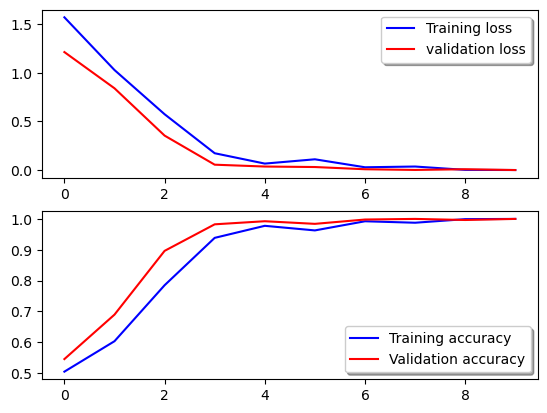

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [18]:

Y=model.predict(xt)


ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 251, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer 'model' (type Functional).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'model' (type Functional):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None


In [ ]:
y_class=[np.argmax(x) for x in Y_pred]
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

In [ ]:
predicted_class[5]

In [ ]:
def plot_actual_predicted(images, pred_classes):
    fig, axes = plt.subplots(1, 5, figsize=(16, 15))
    axes = axes.flatten()
  
  # plot
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("Base reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')
  # plot image
    for k,v in images.items():
        ax = axes[int(k)]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"True: %s \nPredict: %s" % (labels[k], labels[pred_classes[k]]))
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
plot_actual_predicted(images_dict, predicted_class)

In [ ]:
print(classification_report(y_test_new,y_class))


In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='hot_r')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()